# First SageMaker Notebook

In [1]:
# Define IAM role
import boto3
from sagemaker import get_execution_role

In [2]:
bucket = 'sagemaker-test-mdebbich'
# If you don't have any specific bucket you can automatically create one using :
# bucket = Session().default_bucket()

prefix = 'test-iris/kmeans'
role = get_execution_role()
role

'arn:aws:iam::553243691765:role/service-role/AmazonSageMaker-ExecutionRole-20190304T180164'

# Data Exploration

In [3]:
import matplotlib.pyplot as plt
from sklearn import datasets
import pandas as pd
import numpy as np

Load Iris Data :

In [4]:
iris = datasets.load_iris()
iris_data = pd.DataFrame(iris["data"], columns= iris["feature_names"])
iris_data["target"] = iris["target"]
iris_data["species"] = iris["target"]
iris_data["species"] = iris_data["species"].astype("category").cat.rename_categories(iris["target_names"])

In [5]:
iris_data.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,species
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


Text(0,0.5,'Petal width')

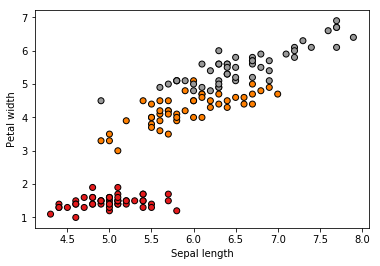

In [71]:
# Plot the training points
plt.scatter(iris_data.iloc[:, 0], iris_data.iloc[:, 2], c=iris_data["target"], cmap=plt.cm.Set1, edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Petal width')


# Model Training

In [7]:
from sagemaker import KMeans
from sklearn.model_selection import train_test_split

In [8]:
train, test = train_test_split(iris_data, train_size=0.8)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [9]:
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

In [10]:
train.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,species
0,4.9,2.4,3.3,1.0,1,versicolor
1,6.3,3.4,5.6,2.4,2,virginica
2,5.1,3.8,1.6,0.2,0,setosa
3,7.7,3.0,6.1,2.3,2,virginica
4,5.0,3.4,1.6,0.4,0,setosa


Define Training job:

In [11]:
data_location = 's3://{}/{}/train_data'.format(bucket, prefix)
output_location = 's3://{}/{}/output'.format(bucket, prefix)

print('training data will be uploaded to: {}'.format(data_location))
print('training artifacts will be uploaded to: {}'.format(output_location))

kmeans = KMeans(
    role=role,
    train_instance_count=1,
    train_instance_type='ml.m5.large',
    output_path=output_location,
    k=3,
    data_location=data_location
)


training data will be uploaded to: s3://sagemaker-test-mdebbich/test-iris/kmeans/train_data
training artifacts will be uploaded to: s3://sagemaker-test-mdebbich/test-iris/kmeans/output


Convert input to Sagemaker's kmeans expected format:

In [24]:
train_input = np.array(train.iloc[:, :4]).astype('float32')
train_input[:10, :]

array([[4.9, 2.4, 3.3, 1. ],
       [6.3, 3.4, 5.6, 2.4],
       [5.1, 3.8, 1.6, 0.2],
       [7.7, 3. , 6.1, 2.3],
       [5. , 3.4, 1.6, 0.4],
       [7.1, 3. , 5.9, 2.1],
       [6.3, 3.3, 4.7, 1.6],
       [6.1, 3. , 4.6, 1.4],
       [5.1, 3.8, 1.9, 0.4],
       [6. , 3.4, 4.5, 1.6]], dtype=float32)

Run the training job:

In [25]:
kmeans.fit(kmeans.record_set(train_input))

INFO:sagemaker:Creating training-job with name: kmeans-2019-03-07-17-14-26-104


2019-03-07 17:14:26 Starting - Starting the training job...
2019-03-07 17:14:27 Starting - Launching requested ML instances...
2019-03-07 17:15:26 Starting - Preparing the instances for training.........
2019-03-07 17:16:45 Downloading - Downloading input data..
Docker entrypoint called with argument(s): train
[03/07/2019 17:17:07 INFO 139698254088000] Reading default configuration from /opt/amazon/lib/python2.7/site-packages/algorithm/resources/default-input.json: {u'_enable_profiler': u'false', u'_tuning_objective_metric': u'', u'_num_gpus': u'auto', u'local_lloyd_num_trials': u'auto', u'_log_level': u'info', u'_kvstore': u'auto', u'local_lloyd_init_method': u'kmeans++', u'force_dense': u'true', u'epochs': u'1', u'init_method': u'random', u'local_lloyd_tol': u'0.0001', u'local_lloyd_max_iter': u'300', u'_disable_wait_to_read': u'false', u'extra_center_factor': u'auto', u'eval_metrics': u'["msd"]', u'_num_kv_servers': u'1', u'mini_batch_size': u'5000', u'half_life_time_size': u'0', u'

# Model Deployment

In [29]:
kmeans_predictor = kmeans.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    endpoint_name='kmeans'
)

INFO:sagemaker:Creating model with name: kmeans-2019-03-07-17-21-48-825
INFO:sagemaker:Creating endpoint with name kmeans


---------------------------------------------------------------------------!

# Endpoint Test

In [30]:
test_data_location = 's3://{}/{}/test_data'.format(bucket, prefix)

In [31]:
test_data_location

's3://sagemaker-test-mdebbich/test-iris/kmeans/test_data'

In [63]:
test_set = np.array(test.iloc[:, :4]).astype('float32')

In [64]:
test_set[:10, :]

array([[5.4, 3.9, 1.7, 0.4],
       [6.7, 3.1, 4.7, 1.5],
       [5.4, 3.7, 1.5, 0.2],
       [5. , 2.3, 3.3, 1. ],
       [6. , 3. , 4.8, 1.8],
       [6. , 2.7, 5.1, 1.6],
       [5.1, 3.5, 1.4, 0.2],
       [4.5, 2.3, 1.3, 0.3],
       [7.6, 3. , 6.6, 2.1],
       [6.2, 3.4, 5.4, 2.3]], dtype=float32)

In [65]:
results = kmeans_predictor.predict(test_set)

In [66]:
clusters = np.array([r.label['closest_cluster'].float32_tensor.values[0] for r in results])

In [67]:
clusters

array([0., 1., 0., 1., 1., 1., 0., 0., 2., 2., 1., 0., 1., 0., 0., 0., 2.,
       1., 2., 2., 2., 1., 2., 1., 2., 0., 0., 0., 1., 1.])

Text(0,0.5,'Petal length')

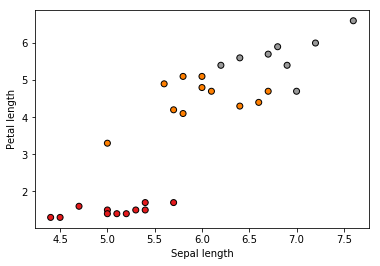

In [70]:
# Plot the training points
plt.scatter(test_set[:, 0], test_set[:, 2], c=clusters, cmap=plt.cm.Set1, edgecolor='k')
plt.xlabel('Sepal length')
plt.ylabel('Petal length')

In [ ]:
# Remove the endpoint:
# kmeans_predictor.delete_endpoint()